# DATA ENGINEERING: ENTREPRENEURSHIP & REAL ESATE 
### Data Engineering Capstone Project

#### Project Summary
This project is to build a data pipeline for data scientists to study the impact of entrepreneurship on real estate market, such as house value.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### Step 1: Scope the Project and Gather Data

#### Scope 
##### This project is to build a data pipeline solution through transforming data in Spark then loading data to NoSQL Cassandra database to study the impact of entrepreneurship on real estate market over time. Data is extracted through two different data sources:
* Property Assessment Data provided by the City of Edmonton (API): https://data.edmonton.ca/City-Administration/Property-Assessment-Data-Historical-/qi6a-xuwt
* Business Licenses Data in data/business_licenses_edmonton.csv

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 
* Property Assessment Data provided by the City of Edmonton (API) coming from https://data.edmonton.ca/City-Administration/Property-Assessment-Data-Historical-/qi6a-xuwt
Property Assessment Data includes the granular information of all the properties in Edmonton, such as its account number, assessed value, assessment_year, whether it has a garage or not, the property's house_number, its latitude, legal description, longitude, lot_size, neighbourhood_name, street_name, suite, year_built, and zoning.
* Business Licenses Data in data/business_licenses_edmonton.csv coming from https://data.edmonton.ca/Sustainable-Development/City-of-Edmonton-Business-Licenses/qhi4-bdpu.
This dataset includes information regarding to a business license registration, such as its category, trade name, address, licence number, licence status (issue or renewal), issue date, neighbourhood, latitude, and longitude.

##### The final solution should display the number of business licenses issued each year along with the average house value in Edmonton.

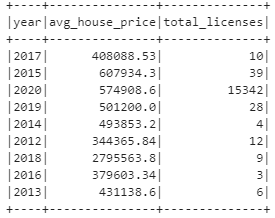

In [11]:
from IPython.display import Image
Image(filename='end_solution.PNG') 

### Step 2: Explore and Assess the Data
#### Explore the Data 
* The property assessment data has a lot of missing values in columns such as point_location, year_built. Since we are not interested in those information for now, we can just exclude them. 
* The business licenses data has missing values in the address column. Since we are not interested in this information, we could also exclude this column. Additionally, this data set captures of renewed business licenses and new issued. Since we want to know how entrepreneurship impacts real estate market, we will filter out this data set by License Status = "ISSUED" in the next step.

In [12]:
!pip install sodapy
import os
from pyspark import SparkContext
from pyspark.sql import SQLContext
import cassandra
from cassandra.cluster import Cluster
import pandas as pd
import csv
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, date_format
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark import SparkConf
from sodapy import Socrata

In [18]:
# Explore property value data by making an API call
client = Socrata("data.edmonton.ca", None)
results = client.get("qi6a-xuwt")
results_df = pd.DataFrame.from_records(results)
results_df

,:@computed_region_5jki_au6x,:@computed_region_7ccj_gre3,:@computed_region_ecxu_fw7u,:@computed_region_izdr_ja4x,:@computed_region_mnf4_kaez,account_number,assessed_value,assessment_year,garage,house_number,...,mill_class_1,mill_class_2,neighbourhood_name,point_location,street_name,suite,tax_class_pct_1,tax_class_pct_2,year_built,zoning
0,NaN,NaN,NaN,NaN,NaN,1068451,7597000,2015,N,4007,...,RESIDENTIAL,NaN,SUMMERSIDE,NaN,SAVARYN DRIVE SW,NaN,100,NaN,NaN,RPL
1,NaN,NaN,NaN,NaN,NaN,1152594,12500,2012,N,17310,...,COMMERCIAL,NaN,ELSINORE,NaN,97 STREET NW,NaN,100,NaN,1935,AG
2,NaN,NaN,NaN,NaN,NaN,1153568,88000,2012,N,NaN,...,COMMERCIAL,NaN,BATTERY OIL FIELDS,NaN,NaN,NaN,100,NaN,1991,AG
3,NaN,NaN,NaN,NaN,NaN,1153626,0,2014,N,NaN,...,COMMERCIAL,NaN,BATTERY OIL FIELDS,NaN,NaN,NaN,100,NaN,1989,AG
4,NaN,NaN,NaN,NaN,NaN,1248590,49500,2016,N,NaN,...,COMMERCIAL,NaN,TERWILLEGAR AREA,NaN,NaN,NaN,100,NaN,NaN,A
5,NaN,NaN,NaN,NaN,NaN,1273424,0,2014,N,NaN,...,COMMERCIAL,NaN,BATTERY OIL FIELDS,NaN,NaN,NaN,100,NaN,1989,AG
6,NaN,NaN,NaN,NaN,NaN,1328749,15500,2016,N,NaN,...,COMMERCIAL,NaN,SPUR LINES,NaN,NaN,NaN,100,NaN,NaN,PU
7,4,10,96,3,8,1650860,0,2014,N,NaN,...,RESIDENTIAL,NaN,THORNCLIFF,"{'type': 'Point', 'coordinates': [-113.61627, ...",NaN,NaN,100,NaN,NaN,RF1
8,4,34,94,3,1,1809011,1536500,2012,N,8535,...,COMMERCIAL,NaN,ALDERGROVE,"{'type': 'Point', 'coordinates': [-113.63517, ...",182 STREET NW,NaN,100,NaN,1979,AP
9,NaN,NaN,NaN,NaN,NaN,2914836,358500,2018,Y,13004,...,RESIDENTIAL,NaN,INGLEWOOD,NaN,115 AVENUE NW,NaN,100,NaN,1964,RF3


In [19]:
# Explore business licenses data by loading the csv file
data = pd.read_csv(
        "data/business_licenses_edmonton.csv",
        dtype={"Neighbourhood ID": int, "Latitude": float, "Longitude": float},
        usecols=['Category', 'Trade Name', 'Address', 'Licence Number', 'Licence Status', 'Issue Date', 'Neighbourhood ID', 'Neighbourhood', 'Latitude', 'Longitude'],
        parse_dates=['Issue Date'],
)
data

,Category,Trade Name,Address,Licence Number,Licence Status,Issue Date,Neighbourhood ID,Neighbourhood,Latitude,Longitude
0,General Business,TECHSPERT SYSTEMS,NaN,106807972-002,ISSUED,2021-06-09,4240,La Perle,NaN,NaN
1,General Contractor,3D-RENOS,NaN,87575800-002,RENEWAL NOTICE,2020-08-15,3430,Wellington,NaN,NaN
2,Minor Retail Store,SATELLITE DEPOT.CA INC.,10183 - 34 AVENUE NW,343769392-002,ISSUED,2021-07-01,6570,Parsons Industrial,53.466751,-113.489971
3,General Contractor,LAWN KING,NaN,326605689-002,RENEWAL NOTICE,2020-08-07,5462,Chappelle Area,NaN,NaN
4,General Contractor,TEKLU & TIGIST CLEANING SERVICES LTD,NaN,176099789-002,ISSUED,2021-07-01,1030,Central McDougall,NaN,NaN
5,Minor Retail Store,LACE AND LEAVES STUDIO,"2, 5408 - 53 AVENUE NW",324274028-002,RENEWAL NOTICE,2020-08-14,6640,Roper Industrial,53.490995,-113.421761
6,Minor Retail Store,SHANTAM INTERIORS,"208, 8135 - 102 STREET NW",365240242-002,ISSUED,2021-07-01,6610,Ritchie,53.517751,-113.493378
7,Spectator Entertainment Establishment,THE REC ROOM,"2065, 8882 - 170 STREET NW",340135004-002,RENEWAL NOTICE,2020-07-21,4520,Summerlea,53.522271,-113.618482
8,Minor Retail Store,KELEGANT STUDIOS,NaN,128008843-002,RENEWAL NOTICE,2020-08-12,6450,Menisa,NaN,NaN
9,Rental Accommodation,HOLME'S PLACE,9515 - 110A AVENUE NW,68260632-001,RENEWAL NOTICE,2020-08-14,1140,McCauley,53.558667,-113.487094


#### Cleaning Steps
Document steps necessary to clean the data

In [8]:
# Performing cleaning tasks here
spark = create_spark_session()
sparkDF_business_license=spark.read.parquet("output_data/business_data.parquet")
sparkDF_house_value=spark.read.parquet("output_data/house_value_data.parquet")
sparkDF_business_license.printSchema()
sparkDF_business_license.show()
# extract columns to create neighborhoods table
neighborhoods_table = sparkDF_business_license.select(["neighbourhoodId", "neighbourhood", "latitude", "longitude"]).dropDuplicates().sort("neighbourhoodId")
# write neighborhoods table to parquet files partitioned by neighbourhoodId
#neighborhoods_table.write.partitionBy(["neighbourhoodId"]).parquet("output_data/neighbors.parquet")

root
 |-- category: string (nullable = true)
 |-- tradeName: string (nullable = true)
 |-- address: string (nullable = true)
 |-- licenceNumber: string (nullable = true)
 |-- licenceStatus: string (nullable = true)
 |-- issueDate: date (nullable = true)
 |-- neighbourhoodId: integer (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)

+--------------------+--------------------+--------------------+-------------+--------------+----------+---------------+--------------------+---------+-----------+
|            category|           tradeName|             address|licenceNumber| licenceStatus| issueDate|neighbourhoodId|       neighbourhood| latitude|  longitude|
+--------------------+--------------------+--------------------+-------------+--------------+----------+---------------+--------------------+---------+-----------+
|    General Business|   TECHSPERT SYSTEMS|                 NaN|106807972-002|   

In [9]:
spark = create_spark_session()
sparkDF_business_license=spark.read.parquet("output_data/business_data.parquet")
sparkDF_house_value=spark.read.parquet("output_data/house_value_data.parquet")
#sparkDF_business_license.show()
# extract columns to create business_licenses table & filter by only Issued Business License
licenses_table = sparkDF_business_license.select(["category", "tradeName", "address", "licenceNumber", "licenceStatus", "issueDate", "neighbourhoodId"]).dropDuplicates().sort("neighbourhoodId").filter("licenceStatus == 'ISSUED'")
# write neighborhoods table to parquet files partitioned by neighbourhoodId
business_licenses = licenses_table.select(["category", "tradeName", "address", "licenceNumber", "issueDate", "neighbourhoodId"])
#business_licenses.write.partitionBy(["category"]).parquet("output_data/licenses.parquet")

In [10]:
dates = licenses_table.select(["issueDate"])
dates.createOrReplaceTempView("datetime_table")

In [11]:
df3 = spark.sql("SELECT datetime_table.issueDate AS issueDate, year(datetime_table.issueDate) AS year FROM datetime_table")
df3.show()
#df3.write.partitionBy(["year"]).parquet("output_data/years.parquet")

+----------+----+
| issueDate|year|
+----------+----+
|2021-02-09|2021|
|2020-10-13|2020|
|2021-05-21|2021|
|2021-01-05|2021|
|2021-05-06|2021|
|2021-05-10|2021|
|2020-12-22|2020|
|2021-05-28|2021|
|2020-09-25|2020|
|2021-02-28|2021|
|2020-09-17|2020|
|2021-03-02|2021|
|2021-03-05|2021|
|2021-04-14|2021|
|2021-01-21|2021|
|2020-11-05|2020|
|2021-05-21|2021|
|2020-08-27|2020|
|2020-09-17|2020|
|2020-12-15|2020|
+----------+----+
only showing top 20 rows



In [17]:
sparkDF_house_value.createOrReplaceTempView("house_value_table")

In [13]:
spark = create_spark_session()
sparkDF_house_value=spark.read.parquet("output_data/house_value_data.parquet")
sparkDF_house_value.createOrReplaceTempView("house_value_table")
neighborhoods_table=spark.read.parquet("output_data/neighbors.parquet")
neighborhoods_table.createOrReplaceTempView("neighborhood_table")
house_data = spark.sql("SELECT house_value_table.account_number, house_value_table.assessed_value, house_value_table.assessment_year, house_value_table.garage, house_value_table.house_number, house_value_table.mill_class_1, house_value_table.street_name, house_value_table.year_built, house_value_table.zoning, neighborhood_table.neighbourhoodId \
                    FROM house_value_table \
                    LEFT JOIN neighborhood_table ON house_value_table.neighborhood_name = neighborhood_table.neighbourhood")
#house_data.write.parquet("output_data/houses.parquet")

In [23]:
spark = create_spark_session()
business_licenses = spark.read.parquet("output_data/licenses.parquet")
business_licenses.createOrReplaceTempView("license_table")
#years = spark.read.parquet("output_data/years.parquet")
#years.createOrReplaceTempView("years")
#house_value.groupBy("assessment_year").avg("assessed_value").show(truncate=False)
business_license_by_year = spark.sql("SELECT YEAR(issueDate) AS year, COUNT(licenceNumber) AS total_licenses FROM license_table GROUP BY YEAR(issueDate)")
business_license_by_year.createOrReplaceTempView("license_by_year")

In [30]:
spark = create_spark_session()
house_value=spark.read.parquet("output_data/houses.parquet")
house_value.show()
house_value_by_year = house_value.groupBy("assessment_year").avg("assessed_value")
house_value_by_year = house_value_by_year.select(col("assessment_year").alias("year"), col("avg(assessed_value)").alias("avg_house_price"))
house_value_by_year.createOrReplaceTempView("house_value_by_year")

+--------------+--------------+---------------+------+------------+------------+----------------+----------+------+---------------+
|account_number|assessed_value|assessment_year|garage|house_number|mill_class_1|     street_name|year_built|zoning|neighbourhoodId|
+--------------+--------------+---------------+------+------------+------------+----------------+----------+------+---------------+
|       1068451|       7597000|           2015|     N|        4007| RESIDENTIAL|SAVARYN DRIVE SW|         0|   RPL|           null|
|       1152594|         12500|           2012|     N|       17310|  COMMERCIAL|    97 STREET NW|      1935|    AG|           null|
|       1153568|         88000|           2012|     N|           0|  COMMERCIAL|             NaN|      1991|    AG|           null|
|       1153626|             0|           2014|     N|           0|  COMMERCIAL|             NaN|      1989|    AG|           null|
|       1248590|         49500|           2016|     N|           0|  COMMERC

In [36]:
final_df= spark.sql("SELECT house_value_by_year.year, house_value_by_year.avg_house_price, license_by_year.total_licenses FROM house_value_by_year JOIN license_by_year ON house_value_by_year.year = license_by_year.year ORDER BY house_value_by_year.year")
final_df.show()

+----+------------------+--------------+
|year|   avg_house_price|total_licenses|
+----+------------------+--------------+
|2012|346525.72033898305|            12|
|2013|431405.26666666666|             6|
|2014|496238.09523809527|             4|
|2015| 609184.3431372549|            39|
|2016|370249.36734693876|             3|
|2017| 404490.9090909091|            10|
|2018|2324852.0454545454|             9|
|2019|          501705.0|            28|
|2020| 566196.8085106383|         15342|
+----+------------------+--------------+



+----+------------------+--------------+
|year|   avg_house_price|total_licenses|
+----+------------------+--------------+
|2012|346525.72033898305|            12|
|2013|431405.26666666666|             6|
|2014|496238.09523809527|             4|
|2015| 609184.3431372549|            39|
|2016|370249.36734693876|             3|
|2017| 404490.9090909091|            10|
|2018|2324852.0454545454|             9|
|2019|          501705.0|            28|
|2020| 566196.8085106383|         15342|
+----+------------------+--------------+



### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [ ]:
# Write code here

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Perform quality checks here

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

In [ ]:
house_value=spark.read.parquet("output_data/houses.parquet")house_value=spark.read.parquet("output_data/houses.parquet")